# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
# Ваш код здесь
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65** <-ответ
- 66
- 193

In [10]:
# Ваш код здесь
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
pca.fit(X_scaled)

pca.n_components_

np.int64(65)

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51** <-ответ
- 56
- 61

In [11]:
# Ваш код здесь
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
pca.fit(X_scaled)

first_pc_variance = pca.explained_variance_ratio_[0] * 100
first_pc_variance

np.float64(50.738221035013375)

Визуализируйте данные в проекции на первые две главные компоненты.

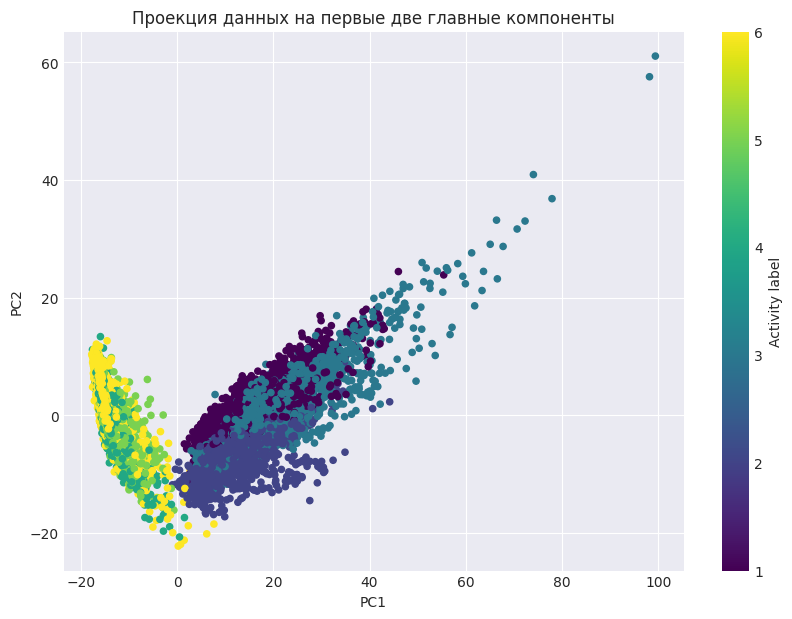

In [12]:
# Ваш код здесь
X_pca = pca.transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Проекция данных на первые две главные компоненты')
plt.colorbar(label='Activity label')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)** <-ответ
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [26]:
# Ваш код здесь
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)

kmeans.fit(X_pca)

y_kmeans = kmeans.labels_

print(np.bincount(y_kmeans))

# MY EXTRA ULTIMATE ALTERNATIVE VERSION OF KMeans
class MyKMeans:
    def __init__(self, n_clusters=6, max_iter=100, tol=1e-4, init='k-means++', random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        if self.init == 'random':
            indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            centroids = X[indices]
        elif self.init == 'k-means++':
            centroids = np.zeros((self.n_clusters, n_features))
            centroids[0] = X[np.random.randint(n_samples)]
            for i in range(1, self.n_clusters):
                dist_sq = np.min(np.linalg.norm(X[:, np.newaxis] - centroids[:i], axis=2)**2, axis=1)
                prob = dist_sq / dist_sq.sum()
                cumulative_prob = np.cumsum(prob)
                r = np.random.rand()
                index = np.searchsorted(cumulative_prob, r)
                centroids[i] = X[index]
        else:
            raise ValueError("init must be 'random' or 'k-means++'")
        return centroids

    def _assign_labels(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            if np.any(labels == i):
                centroids[i] = X[labels == i].mean(axis=0)
            else:
                centroids[i] = X[np.random.randint(0, X.shape[0])]
        return centroids

    def fit(self, X):
        X = np.array(X)
        self.cluster_centers_ = self._initialize_centroids(X)

        for i in range(self.max_iter):
            labels = self._assign_labels(X, self.cluster_centers_)
            new_centroids = self._compute_centroids(X, labels)

            if np.all(np.linalg.norm(new_centroids - self.cluster_centers_, axis=1) < self.tol):
                break
            self.cluster_centers_ = new_centroids

        self.labels_ = self._assign_labels(X, self.cluster_centers_)
        self.inertia_ = np.sum((X - self.cluster_centers_[self.labels_])**2)
        return self

    def predict(self, X):
        X = np.array(X)
        return self._assign_labels(X, self.cluster_centers_)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_



my_kmeans = MyKMeans(n_clusters=n_classes, random_state=RANDOM_STATE)
my_kmeans.fit(X_pca)

y_my_kmeans = my_kmeans.labels_

print(np.bincount(y_my_kmeans))



[2631 2470 1927  279 1343 1649]
[2470 1649 2631 1343  279 1927]


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

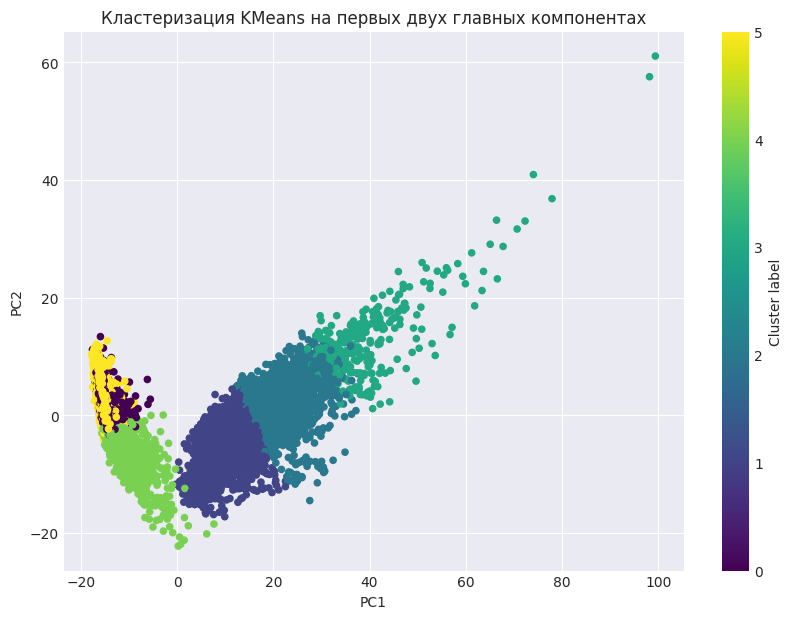

In [27]:
# Ваш код здесь
cluster_labels = y_kmeans

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Кластеризация KMeans на первых двух главных компонентах')
plt.colorbar(label='Cluster label')
plt.show()


Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [28]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**<-ответ (лежание)

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\Users\max_d\AppData\Local\Temp\ipykernel_104156\4123532207.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

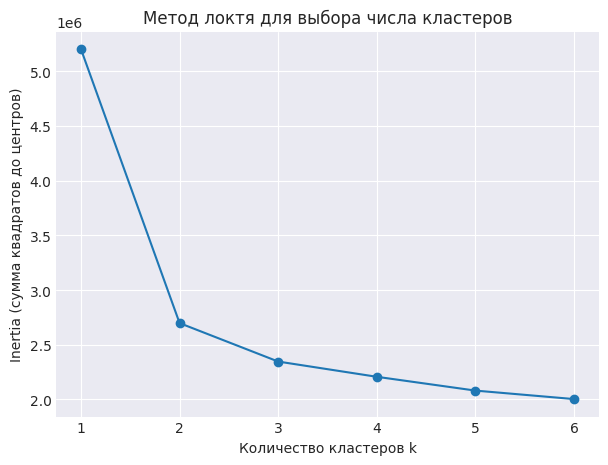

In [30]:
# Ваш код здесь
inertia = []

for k in tqdm_notebook(range(1, n_classes + 1)):
    km = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=RANDOM_STATE
    )
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel("Количество кластеров k")
plt.ylabel("Inertia (сумма квадратов до центров)")
plt.title("Метод локтя для выбора числа кластеров")
plt.grid(True)
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2** <-ответ
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [31]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [34]:
# Ваш код здесь
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

ag = AgglomerativeClustering(
    n_clusters=n_classes,
    linkage='ward'
).fit(X_pca)

ag_labels = ag.labels_

ari_ag = adjusted_rand_score(y, ag_labels)

kmeans_labels = kmeans.labels_

ari_kmeans = adjusted_rand_score(y, kmeans_labels)

ari_ag, ari_kmeans


(0.49362763373004886, 0.4198070012602345)

**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**<-ответ
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**<-ответ
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**<-ответ

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [35]:
# Ваш код здесь
#
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [41]:
# Ваш код здесь
grid_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
grid_svc.fit(X_train_scaled, y_train)

best_svc = grid_svc.best_estimator_

In [42]:
# Ваш код здесь
print("Лучшие параметры:", grid_svc.best_params_)
print("Точность (score) на обучающей выборке (CV):", grid_svc.best_score_)
print("Точность на отложенной тестовой выборке:", best_svc.score(X_test_scaled, y_test))

Лучшие параметры: {'C': 0.1}
Точность (score) на обучающей выборке (CV): 0.9381145554917194
Точность на отложенной тестовой выборке: 0.9623345775364778


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**<-ответ
- 1
- 10

In [43]:
y_predicted = best_svc.predict(X_test_scaled)

In [44]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,443,588,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**<-ответ

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

In [45]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)

print(f"Количество признаков до PCA: {X_train_scaled.shape[1]}")
print(f"Количество признаков после PCA: {X_train_pca.shape[1]}")

svc_pca = LinearSVC(random_state=RANDOM_STATE, dual='auto')
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_svc_pca = GridSearchCV(svc_pca, svc_params, cv=3, n_jobs=-1)
grid_svc_pca.fit(X_train_pca, y_train)

best_score_pca = grid_svc_pca.best_score_
best_score_full = grid_svc.best_score_

print("\n--- Результаты ---")
print(f"Лучшее качество CV (561 признак): {best_score_full:.4f}")
print(f"Лучшее качество CV (PCA-признаки): {best_score_pca:.4f}")
print(f"Лучшие параметры C (с PCA): {grid_svc_pca.best_params_}")

Количество признаков до PCA: 561
Количество признаков после PCA: 63

--- Результаты ---
Лучшее качество CV (561 признак): 0.9381
Лучшее качество CV (PCA-признаки): 0.8984
Лучшие параметры C (с PCA): {'C': 0.1}




**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- **2%**<-ответ
- 4%
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**<-ответ
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**<-ответ

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

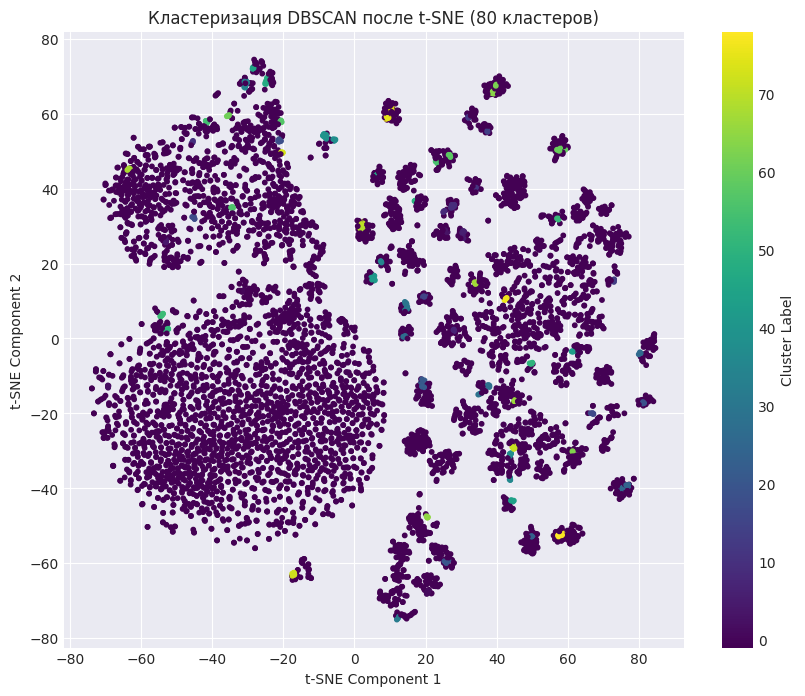

Количество найденных кластеров (включая шум -1): 80
Доля точек, классифицированных как шум (-1): 0.9377


In [46]:
# Ваш код здесь
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, n_jobs=-1, init='pca', learning_rate='auto')

X_train_tsne = tsne.fit_transform(X_train_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_train_tsne)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_dbscan, cmap='viridis', s=10)
plt.title(f'Кластеризация DBSCAN после t-SNE ({np.unique(labels_dbscan).size} кластеров)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

print(f"Количество найденных кластеров (включая шум -1): {np.unique(labels_dbscan).size}")
print(f"Доля точек, классифицированных как шум (-1): {np.sum(labels_dbscan == -1) / len(labels_dbscan):.4f}")